# 72hr EQS - Neap tide


### This script can be used to find area exceedance of a tracer for 72hr EQS

To assess the long-term risks from Azamethiphos, the full treatment regime is modelled.
Tracer threshold - 40 ng/L.  
EQS area - 0.5 km2.  
The area of the chemical plume exceeding 40ng/l (72-hour EQS) is plotted.

In [1]:
import xarray as xr
import tfv.xarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator

User inputs

In [2]:
#Read the tuflowfv output
file_path_Neap_SC01 = r"X:\Scratch1\aqua_dis_3hr_neap_001.nc"

#Specify the tracer threshold
my_thresholds = [40]


Read in Files

In [3]:
#open the dataset as an array
fv_Neap_SC01 = xr.open_dataset(file_path_Neap_SC01,decode_times=False).tfv

#Extract data at a certain depth range. Fox ex below will extract data for the top 4m.
fv_2d_trace_Neap_SC01 =fv_Neap_SC01.get_sheet('TRACE_1',datum='depth',limits=(0,4))

...extracting sheet data: 100%|████████████████████████████████████████████████████| 1225/1225 [00:30<00:00, 40.48it/s]


In [4]:
# Specify start,end time and final treatment time
Neap_Start_Time = pd.to_datetime('2022-10-13 00:00:00', format='%Y-%m-%d %H:%M:%S')
#Neap_End_Time = pd.to_datetime('2018-11-24 10:00:00', format='%Y-%m-%d %H:%M:%S')
Neap_Final_Treatment = pd.to_datetime('2022-10-19 04:00:00', format='%Y-%m-%d %H:%M:%S')

Convert time to hours from start

In [5]:
df_Neap_SC01 = pd.DataFrame(index=fv_Neap_SC01['Time'])
df_Neap_SC01.index = df_Neap_SC01.index.strftime('%d/%m/%Y %H:%M:%S')
df_Neap_SC01.index = (pd.to_datetime(df_Neap_SC01.index,format='%d/%m/%Y %H:%M:%S') - Neap_Final_Treatment) / pd.Timedelta(hours=1)

Calculate areas

In [6]:
for tr in my_thresholds:

    ind = fv_2d_trace_Neap_SC01['TRACE_1'] > tr #This is nTimesteps X nCells
    area_filtered = fv_2d_trace_Neap_SC01['cell_A'].values[None,] * ind #That magical None will handle broadcasting so that the shapes match.Equivalent to doing ones (nTimesteps)X if you were in Matlab
    total_area = area_filtered.sum(dim='NumCells2D')
    total_area_km2 = total_area.values / 1000000 # Convert total area from m² to km²
    total_area_km2 = total_area_km2.reshape(-1, 1) # Reshape array to match index length
    df_Neap_SC01[f'Reintraid'] = total_area_km2      

Check the maximum value for the area and area value at the EQS

In [7]:
# Convert the Series to a DataFrame
df = df_Neap_SC01[f'ABC_farm'].reset_index()
df.columns = ['time', 'area']

# Find the maximum area and its corresponding value
max_area_row = df[df['area'] == df['area'].max()]

print("DataFrame:")
print(df)

print("\nMaximum Area Row:")
print(max_area_row)

#Find the value for 'area' when the time is closest to 72 hours
target_time = 72.0
eqs_area = df.iloc[(df['time'] - target_time).abs().idxmin()]

print("eqs_area:")
print(eqs_area)


DataFrame:
            time  area
0    -148.000000   0.0
1    -147.666944   0.0
2    -147.333333   0.0
3    -147.000000   0.0
4    -146.666944   0.0
...          ...   ...
1220  258.666667   0.0
1221  259.000000   0.0
1222  259.333056   0.0
1223  259.666667   0.0
1224  260.000000   0.0

[1225 rows x 2 columns]

Maximum Area Row:
     time      area
258 -62.0  0.456518
eqs_area:
time    72.0
area     0.0
Name: 660, dtype: float64


Calculate EQS percentage

In [8]:
# Given EQS value and maximum area
eqs_value = 0.054
area_at_EQS = 0.0

# Calculate the maximum area as a percentage of EQS
percentage_of_eqs = (area_at_EQS / eqs_value) * 100
print(f"Percentage of EQS: {percentage_of_eqs:.2f}%")

Percentage of EQS: 0.00%


Save the df as a  csv

In [9]:
# Save the DataFrame to a CSV file
df.to_csv('../data/RT_72hr_EQS_neap.csv.csv', index=True)

plotting

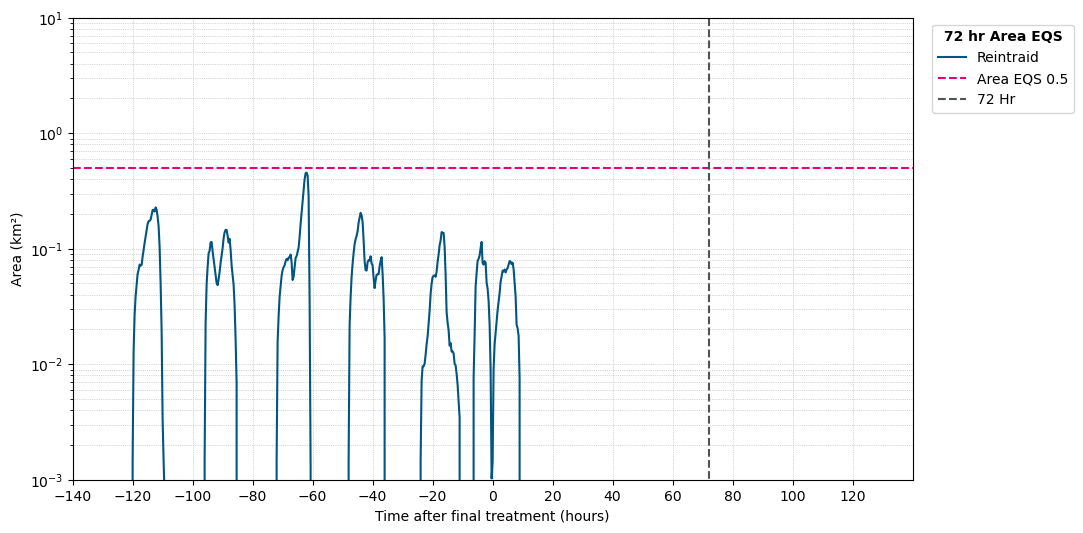

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.1,right=0.8)

df_Neap_SC01.plot(ax=ax, logy=True,color='#005581')
ax.set_xlabel('Time after final treatment (hours)')
ax.set_ylabel('Area (km²)')
ax.set_ylim(0.001, 10)
ax.set_xlim(-140, 140)
ax.set_xticks(np.arange(-140, 140, 20))

#Add EQS lines
ax.hlines(y=0.5, xmin=-140, xmax=140, colors='#E20177', linestyles='dashed', label='Area EQS 0.5')
ax.vlines(x=72, ymin=0, ymax=10, colors='#4F5650', linestyles='dashed', label='72 Hr')

# Add legend
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, title='72 hr Area EQS')
plt.setp(legend.get_title(), weight='bold')

# Add minor gridlines for the logarithmic y-axis
ax.yaxis.grid(True, which='both', linestyle=':', linewidth=0.5)
ax.xaxis.grid(True, which='major', linestyle=':', linewidth=0.5)

plt.xticks(rotation=0)

# Save plot as PNG image with DPI of 300
fig.savefig('../figures/RT_72hr_eqs_neap.png',dpi=300)

plt.show()